# DraCor API basics

This short chapter introduces the DraCor REST API and shows how to access it **directly with `requests`**. You will list available corpora and count plays in a few corpora using simple HTTP calls. The approach mirrors the original *API Tutorial* and keeps everything transparent and reproducible.


> **Learning goals**
> - Understand the base URL and how to build API requests.
> - List available corpora and read their abbreviations.
> - Retrieve and summarise plays for selected corpora.
>
> **Requirements**
> - Python (3.9+), internet connection.
> - Packages: `requests`, `pandas`, `matplotlib` (already in this project’s `requirements.txt`).
>
> **What you'll do**
> 1. Set a base API URL.  
> 2. Fetch `/corpora` and inspect results.  
> 3. Pick a few corpus abbreviations and count their plays.  
> 4. Make a tiny bar chart.


## Concepts: REST, base URL, and endpoints

- **REST API**: You request data over HTTP by visiting specific URLs and the server responds with JSON.
- **Base URL**: The common prefix for all API endpoints in DraCor:  
  `https://dracor.org/api/v1/`
- **Endpoint**: The path you append to the base URL to request something specific. Examples:
  - `corpora` → `https://dracor.org/api/v1/corpora`
  - `corpora/{name}/plays` → `https://dracor.org/api/v1/corpora/ger/plays` (here `{name}` is the **abbreviation** of a corpus, e.g. `ger`, `eng`, `rus`).
- **Abbreviation / corpus name**: In the `/corpora` response, the key `name` contains the short identifier you use in other endpoints.


In [11]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

API_URL = "https://dracor.org/api/v1/"
print("Base URL:", API_URL)

Base URL: https://dracor.org/api/v1/


## 1) List corpora

Request the list of corpora and inspect the first few entries. The `name` key is the abbreviation that you'll use in subsequent endpoints.


In [12]:
corpus_list = requests.get(API_URL + "corpora").json()

# show the first few abbreviations ("name") and titles
rows = [{"name": c.get("name"), "title": c.get("title", "")} for c in corpus_list]
pd.DataFrame(rows).head(10)

,name,title
0,als,Alsatian Drama Corpus
1,am,American Drama Corpus
2,bash,Bashkir Drama Corpus
3,cal,Calderón Drama Corpus
4,dutch,Dutch Drama Corpus
5,eng,English Drama Corpus
6,fre,French Drama Corpus
7,ger,German Drama Corpus
8,gersh,German Shakespeare Drama Corpus
9,greek,Greek Drama Corpus


## 2) Count plays in selected corpora

Pick a few corpus abbreviations from the table above (e.g., `ger`, `eng`, `rus`, `dutch`) and count how many plays each contains.


In [13]:
if "abbrevs" not in globals():
    corpus_list = requests.get(API_URL + "corpora", timeout=20).json()
    abbrevs = [c.get("name") for c in corpus_list if c.get("name")]

targets = ["cal", "eng", "rus", "dutch"]
targets = [t for t in targets if t in abbrevs] or abbrevs[:4]
print("Using corpora:", targets)

def count_plays_csv(corpus_abbr: str) -> int:
    """
    Count plays in a corpus from the CSV metadata endpoint.
    This mirrors the original tutorial: /corpora/{name}/metadata with Accept: text/csv
    """
    url = f"{API_URL}corpora/{corpus_abbr}/metadata"
    r = requests.get(url, headers={"Accept": "text/csv"}, timeout=30)
    r.raise_for_status()
    # Read CSV into a DataFrame; number of rows == number of plays
    df = pd.read_csv(io.StringIO(r.text))
    return len(df)

rows, errors = [], []
for abbr in targets:
    try:
        n = count_plays_csv(abbr)
        rows.append({"corpus": abbr, "n_plays": n})
    except Exception as e:
        errors.append({"corpus": abbr, "error": str(e)})

if rows:
    df_counts = pd.DataFrame(rows).sort_values("n_plays", ascending=False).reset_index(drop=True)
    display(df_counts)
else:
    print("No successful responses.")

if errors:
    print("\nErrors:")
    display(pd.DataFrame(errors))

Using corpora: ['cal', 'eng', 'rus', 'dutch']


,corpus,n_plays
0,eng,435
1,rus,212
2,cal,205
3,dutch,186


## 3) Visualise a tiny summary

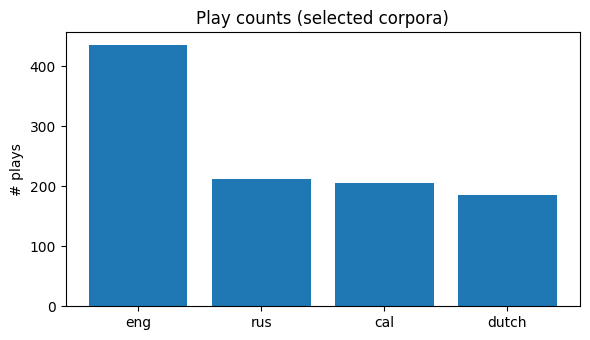

In [14]:
if not df_counts.empty:
    plt.figure(figsize=(6,3.5))
    plt.bar(df_counts["corpus"], df_counts["n_plays"])
    plt.title("Play counts (selected corpora)")
    plt.ylabel("# plays")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No results to plot.")

## Exercise

1. Replace `targets` with four different corpora from the table in step 1 and re-run the cells.
2. For one of your corpora, list the first five play titles:
   ```python
   plays = requests.get(API_URL + "corpora/ger/plays").json()
   pd.DataFrame([{"id": p.get("id"), "title": p.get("title", "")} for p in plays]).head()
   ```
3. Optional: Add a column for the **year** (if present) and compute the earliest/latest play in the corpus.


> **Takeaways**
> - An API call is just a URL (`base` + `endpoint`).  
> - The `name` field from `/corpora` is the key you plug into other endpoints.  
> - `requests.get(...).json()` gives you a Python list/dict you can turn into a DataFrame quickly.
